In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def plot_robustness_with_baselines(robustness_logs, stage1, stage2, out_path="robustness_with_baselines.png"):
    """
    Plot DDQN robustness versus least_loaded and random baselines across load_decay values.

    Inputs:
        robustness_logs : pd.DataFrame
            Columns required: ['episode','agent','seed','reward','latency','overload_freq','load_decay']
        stage1 : int
            Number of episodes in Stage 1
        stage2 : int
            Number of episodes in Stage 2
        out_path : str
            Path to save the output figure
    """
    # Use the final evaluation window (last 50 episodes)
    last_ep = stage1 + stage2
    tail = robustness_logs[robustness_logs["episode"] > last_ep - 50].copy()

    # Aggregate per agent x load_decay
    agg = tail.groupby(["load_decay","agent"], as_index=False).agg(
        mean_reward=("reward","mean"),
        se_reward=("reward", lambda x: x.std(ddof=1)/np.sqrt(max(len(x),1))),
        n=("reward","size")
    )

    # Welch's t-tests: DDQN vs baselines per load_decay
    tests = []
    for ld, sub in tail.groupby("load_decay"):
        ddqn = sub[sub["agent"]=="ddqn"]["reward"].values
        for base in ["least_loaded","random"]:
            b = sub[sub["agent"]==base]["reward"].values
            if len(ddqn) > 1 and len(b) > 1:
                tstat, pval = stats.ttest_ind(ddqn, b, equal_var=False)  # Welch's test
                tests.append({"load_decay": ld, "baseline": base, "t": tstat, "p": pval})
    tests_df = pd.DataFrame(tests).sort_values(["load_decay","baseline"])

    # Plot grouped bars with 95% CI
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({"font.family":"serif","font.size":12})
    fig, ax = plt.subplots(figsize=(9,5))
    palette = {"ddqn":"#1f77b4","least_loaded":"#2ca02c","random":"#d62728"}

    # Bar plot (means only)
    sns.barplot(
        data=agg, x="load_decay", y="mean_reward", hue="agent",
        hue_order=["ddqn","least_loaded","random"],
        palette=palette, errorbar=None, dodge=True, ax=ax
    )

    # Add 95% CI manually
    agents = ["ddqn","least_loaded","random"]
    xcats = sorted(agg["load_decay"].unique())
    width = 0.8
    n_hue = len(agents)
    barw = width / n_hue
    x_positions = {}
    for i, ld in enumerate(xcats):
        center = i
        for j, ag in enumerate(agents):
            xpos = center - width/2 + barw/2 + j*barw
            x_positions[(ld, ag)] = xpos

    for _, row in agg.iterrows():
        ld, ag = row["load_decay"], row["agent"]
        y, se = row["mean_reward"], row["se_reward"]
        if np.isfinite(se):
            yerr = 1.96 * se
            ax.errorbar(
                x_positions[(ld, ag)], y, yerr=yerr,
                fmt='none', ecolor='k', elinewidth=1.2, capsize=4, capthick=1.2, zorder=10
            )

    ax.set_title("Robustness to Traffic: DDQN vs Baselines (Final Window)")
    ax.set_xlabel("Load Decay (Higher = Slower Traffic)")
    ax.set_ylabel("Final Average Reward (less negative is better)")
    ax.legend(title="Agent", frameon=False, loc="upper right")
    ax.axhline(0, color="black", linewidth=0.8)
    plt.tight_layout()
    plt.savefig(out_path, dpi=600, bbox_inches="tight")
    print(f"Saved: {out_path}")

    # Print Welch t-tests
    if not tests_df.empty:
        print("\nWelch's t-tests (DDQN vs baseline) per load_decay:")
        print(tests_df.to_string(index=False))


In [3]:
# ===============================================
# DDQN with Prioritized Replay on EdgeResourceEnv
# Requires: gymnasium, torch, numpy, matplotlib, seaborn, scipy
# ===============================================

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from scipy.stats import ttest_ind
import time
import matplotlib.pyplot as plt
import seaborn as sns

# =====================
# Seed
# =====================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# =====================
# Environment
# =====================
class EdgeResourceEnv(gym.Env):
    """Simulated edge node resource management"""
    metadata = {'render.modes': ['human']}

    def __init__(self, num_nodes=3, capacity=100.0, base_latency=1.0,
                 base_decay_rate=0.1, decay_jitter=0.03,
                 latency_penalty_power=2.0, overload_penalty_factor=5.0,
                 overload_threshold_factor=0.9, catastrophic_factor=1.1):
        super().__init__()
        self.num_nodes = num_nodes
        self.capacity = capacity
        self.base_latency = base_latency
        self.base_decay_rate = base_decay_rate
        self.decay_jitter = decay_jitter
        self.latency_penalty_power = latency_penalty_power
        self.overload_penalty_factor = overload_penalty_factor
        self.overload_threshold = overload_threshold_factor * capacity
        self.catastrophic_threshold = catastrophic_factor * capacity

        self.action_space = spaces.Discrete(num_nodes)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(num_nodes + 1,), dtype=np.float32)

        self.reset()

    def reset(self, seed=None, options=None):
        self.node_loads = np.zeros(self.num_nodes, dtype=np.float32)
        self.current_task = self._generate_task()
        return self._get_state(), {}

    def _generate_task(self):
        return float(np.random.randint(40,60) if random.random() < 0.12 else max(5.0, np.random.normal(15.0, 6.0)))

    def _get_state(self):
        normalized_loads = np.clip(self.node_loads / self.capacity, 0.0, 1.0)
        norm_task = np.clip(self.current_task / self.capacity, 0.0, 1.0)
        return np.concatenate([normalized_loads, [norm_task]]).astype(np.float32)

    def step(self, action):
        decay = self.base_decay_rate + np.random.uniform(-self.decay_jitter, self.decay_jitter)
        self.node_loads *= (1.0 - decay)

        task_load = float(self.current_task)
        projected_load = self.node_loads[action] + task_load
        frac = projected_load / self.capacity
        latency = self.base_latency + (frac ** self.latency_penalty_power)

        overload_penalty = -self.overload_penalty_factor * max(0, projected_load - self.overload_threshold) / self.capacity
        loads_after = self.node_loads.copy()
        loads_after[action] += task_load
        std_penalty = -0.5 * np.std(loads_after) / self.capacity
        peak_reward = -np.max(loads_after) / self.capacity
        reward = -latency + overload_penalty + std_penalty + peak_reward

        self.node_loads[action] += task_load
        done = projected_load > self.catastrophic_threshold
        if done:
            reward -= 50.0
        self.current_task = self._generate_task()
        return self._get_state(), float(reward), done, False, {"latency": latency}

    def render(self, mode='human'):
        print(f"Node loads: {self.node_loads}")

# =====================
# Dueling DQN
# =====================
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden=[128,128]):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.value_fc = nn.Linear(hidden[1],64)
        self.value_out = nn.Linear(64,1)
        self.adv_fc = nn.Linear(hidden[1],64)
        self.adv_out = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        v = torch.relu(self.value_fc(x))
        v = self.value_out(v)
        a = torch.relu(self.adv_fc(x))
        a = self.adv_out(a)
        return v + (a - a.mean(dim=1, keepdim=True))

# =====================
# Prioritized Replay
# =====================
class PrioritizedReplayBuffer:
    def __init__(self, capacity=20000, alpha=0.6, eps=1e-6):
        self.capacity = capacity
        self.alpha = alpha
        self.eps = eps
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos = 0

    def push(self, s,a,r,s2,d):
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity: self.buffer.append((s,a,r,s2,d))
        else: self.buffer[self.pos] = (s,a,r,s2,d)
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos+1)%self.capacity

    def sample(self,batch_size,beta=0.4):
        prios = self.priorities[:len(self.buffer)]
        probs = prios**self.alpha
        probs /= probs.sum()
        idxs = np.random.choice(len(self.buffer), batch_size, p=probs)
        batch = [self.buffer[i] for i in idxs]
        weights = (len(self.buffer)*probs[idxs])**(-beta)
        weights /= weights.max()
        s,a,r,s2,d = zip(*batch)
        return np.vstack(s), np.array(a), np.array(r), np.vstack(s2), np.array(d,dtype=np.float32), idxs, np.array(weights,dtype=np.float32)

    def update_priorities(self, idxs, prios):
        for i,p in zip(idxs,prios): self.priorities[i] = p + self.eps

    def __len__(self): return len(self.buffer)

# =====================
# Training
# =====================
def train_dqn(env, policy_net, device, episodes=1000, steps=200, gamma=0.99,
              lr=1e-4, batch_size=64, epsilon_start=1.0, epsilon_min=0.02,
              epsilon_decay=0.995, target_update_steps=1000, beta_start=0.4,
              beta_increment=1e-4, alpha=0.6, replay_capacity=20000, tau=1.0):

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    target_net = DuelingDQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay = PrioritizedReplayBuffer(capacity=replay_capacity, alpha=alpha)

    epsilon = epsilon_start
    beta = beta_start
    rewards_per_episode = []
    step_count = 0

    for ep in range(episodes):
        state,_ = env.reset()
        total_reward = 0.0
        for t in range(steps):
            step_count += 1
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    st = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = int(policy_net(st).argmax(dim=1).item())

            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            replay.push(state, action, reward, next_state, done)
            state = next_state

            if len(replay) >= batch_size:
                s,a,r,s2,d,idxs,w = replay.sample(batch_size,beta)
                s = torch.FloatTensor(s).to(device)
                s2 = torch.FloatTensor(s2).to(device)
                a = torch.LongTensor(a).unsqueeze(1).to(device)
                r = torch.FloatTensor(r).unsqueeze(1).to(device)
                d = torch.FloatTensor(d).unsqueeze(1).to(device)
                w = torch.FloatTensor(w).unsqueeze(1).to(device)

                curr_q = policy_net(s).gather(1,a)
                next_a = policy_net(s2).argmax(dim=1,keepdim=True)
                next_q = target_net(s2).gather(1,next_a).detach()
                expected_q = r + gamma*next_q*(1-d)

                td_errors = (expected_q - curr_q).detach().squeeze().cpu().numpy()
                replay.update_priorities(idxs, np.abs(td_errors)+1e-6)

                loss = (w*nn.MSELoss(reduction='none')(curr_q,expected_q)).mean()
                optimizer.zero_grad(); loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(),1.0)
                optimizer.step()

                if tau>=1.0:
                    if step_count % target_update_steps==0: target_net.load_state_dict(policy_net.state_dict())
                else:
                    for tp,pp in zip(target_net.parameters(), policy_net.parameters()):
                        tp.data.copy_(tau*tp.data + (1-tau)*pp.data)

                beta = min(1.0, beta+beta_increment)

            if done: break

        epsilon = max(epsilon_min, epsilon*epsilon_decay)
        rewards_per_episode.append(total_reward)
        if ep%50==0 or ep==episodes-1:
            recent = np.mean(rewards_per_episode[-50:])
            print(f"[{time.strftime('%H:%M:%S')}] Episode {ep}, Reward: {total_reward:.2f}, RecentAvg(50): {recent:.3f}, Epsilon: {epsilon:.3f}, ReplayLen: {len(replay)}")

    return rewards_per_episode

# =====================
# Baseline
# =====================
def baseline_least_loaded(env, episodes=500, steps=200):
    rewards = []
    for _ in range(episodes):
        state,_ = env.reset()
        total = 0.0
        for _ in range(steps):
            action = int(np.argmin(env.node_loads))
            state,reward,done,_,_ = env.step(action)
            total += reward
            if done: break
        rewards.append(total)
    return rewards

# =====================
# Main Run
# =====================
if __name__=="__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    low_env = EdgeResourceEnv(num_nodes=3, latency_penalty_power=1.5, overload_penalty_factor=1.0,
                              overload_threshold_factor=0.95, catastrophic_factor=1.2)
    high_env = EdgeResourceEnv(num_nodes=3, latency_penalty_power=2.0, overload_penalty_factor=5.0,
                               overload_threshold_factor=0.9, catastrophic_factor=1.05)

    policy_net = DuelingDQN(low_env.observation_space.shape[0], low_env.action_space.n).to(device)

    hyper = {
        'episodes_stage1':800,'episodes_stage2':1200,'steps':150,'gamma':0.99,'lr':1e-4,
        'batch_size':64,'epsilon_start':1.0,'epsilon_min':0.02,'epsilon_decay':0.995,
        'target_update_steps':800,'beta_start':0.4,'beta_increment':1e-4,
        'alpha':0.6,'replay_capacity':30000,'tau':1.0
    }

    print("--- Stage 1: Low-Penalty ---")
    train_dqn(low_env, policy_net, device, episodes=hyper['episodes_stage1'], steps=hyper['steps'],
              gamma=hyper['gamma'], lr=hyper['lr'], batch_size=hyper['batch_size'],
              epsilon_start=hyper['epsilon_start'], epsilon_min=hyper['epsilon_min'],
              epsilon_decay=hyper['epsilon_decay'], target_update_steps=hyper['target_update_steps'],
              beta_start=hyper['beta_start'], beta_increment=hyper['beta_increment'],
              alpha=hyper['alpha'], replay_capacity=hyper['replay_capacity'], tau=hyper['tau'])

    print("--- Stage 2: High-Penalty ---")
    stage2_rewards = train_dqn(high_env, policy_net, device, episodes=hyper['episodes_stage2'], steps=hyper['steps'],
                               gamma=hyper['gamma'], lr=hyper['lr'], batch_size=hyper['batch_size'],
                               epsilon_start=0.25, epsilon_min=0.01, epsilon_decay=0.998,
                               target_update_steps=hyper['target_update_steps'], beta_start=hyper['beta_start'],
                               beta_increment=hyper['beta_increment'], alpha=hyper['alpha'],
                               replay_capacity=hyper['replay_capacity'], tau=hyper['tau'])

    baseline_rewards = baseline_least_loaded(high_env, episodes=500, steps=hyper['steps'])

    print("\n--- Final Comparison ---")
    print(f"DDQN Avg Reward: {np.mean(stage2_rewards[-100:]):.2f}")
    print(f"Baseline Avg Reward: {np.mean(baseline_rewards[-100:]):.2f}")
    stat,pval = ttest_ind(stage2_rewards[-100:], baseline_rewards[-100:])
    print(f"t-test: stat={stat:.4f}, p={pval:.4f}")


Device: cuda
--- Stage 1: Low-Penalty ---
[19:42:09] Episode 0, Reward: -79.82, RecentAvg(50): -79.825, Epsilon: 0.995, ReplayLen: 14
[19:42:23] Episode 50, Reward: -175.21, RecentAvg(50): -191.037, Epsilon: 0.774, ReplayLen: 3078
[19:42:40] Episode 100, Reward: -171.15, RecentAvg(50): -223.452, Epsilon: 0.603, ReplayLen: 6929
[19:42:58] Episode 150, Reward: -346.27, RecentAvg(50): -223.474, Epsilon: 0.469, ReplayLen: 10822
[19:43:18] Episode 200, Reward: -328.74, RecentAvg(50): -237.384, Epsilon: 0.365, ReplayLen: 15079
[19:43:42] Episode 250, Reward: -347.08, RecentAvg(50): -247.988, Epsilon: 0.284, ReplayLen: 19765
[19:43:56] Episode 300, Reward: -97.94, RecentAvg(50): -177.217, Epsilon: 0.221, ReplayLen: 22573
[19:44:02] Episode 350, Reward: -122.40, RecentAvg(50): -104.786, Epsilon: 0.172, ReplayLen: 23692
[19:44:06] Episode 400, Reward: -116.13, RecentAvg(50): -93.422, Epsilon: 0.134, ReplayLen: 24587
[19:44:10] Episode 450, Reward: -78.27, RecentAvg(50): -85.123, Epsilon: 0.104,

--- Training the DDQN agent for robustness ---
[20:12:09] Episode 0, Avg(100) Reward: -522.81
[20:12:09] Episode 100, Avg(100) Reward: -521.79
[20:12:09] Episode 200, Avg(100) Reward: -515.50
[20:12:10] Episode 300, Avg(100) Reward: -513.29
[20:12:10] Episode 400, Avg(100) Reward: -512.43
[20:12:10] Episode 500, Avg(100) Reward: -512.04
[20:12:14] Episode 600, Avg(100) Reward: -511.91
[20:12:18] Episode 700, Avg(100) Reward: -511.68
[20:12:25] Episode 800, Avg(100) Reward: -517.47
[20:12:34] Episode 900, Avg(100) Reward: -524.16
[20:12:42] Episode 1000, Avg(100) Reward: -520.15
[20:12:51] Episode 1100, Avg(100) Reward: -523.67
[20:12:59] Episode 1200, Avg(100) Reward: -520.18
[20:13:09] Episode 1300, Avg(100) Reward: -524.31
[20:13:20] Episode 1400, Avg(100) Reward: -534.34
[20:13:32] Episode 1500, Avg(100) Reward: -534.62
[20:13:44] Episode 1600, Avg(100) Reward: -534.79
[20:13:56] Episode 1700, Avg(100) Reward: -534.23
[20:14:09] Episode 1800, Avg(100) Reward: -534.54
[20:14:20] Epis

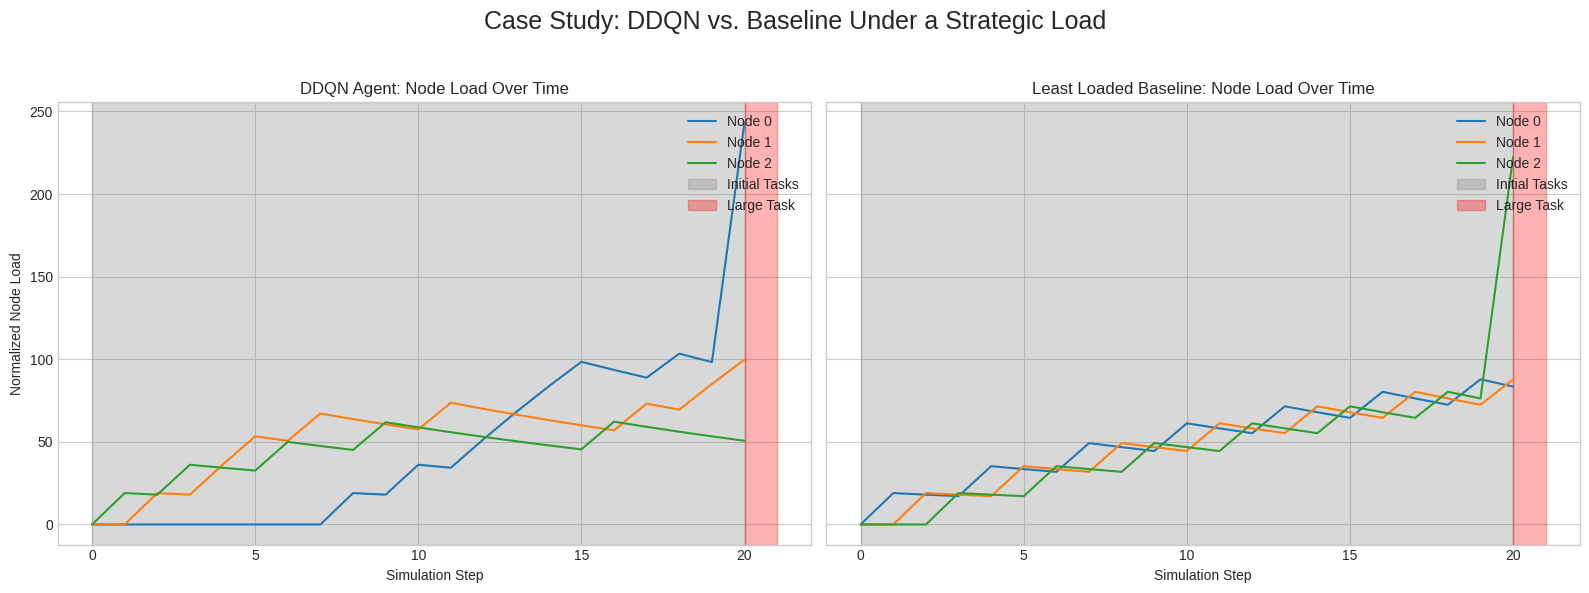

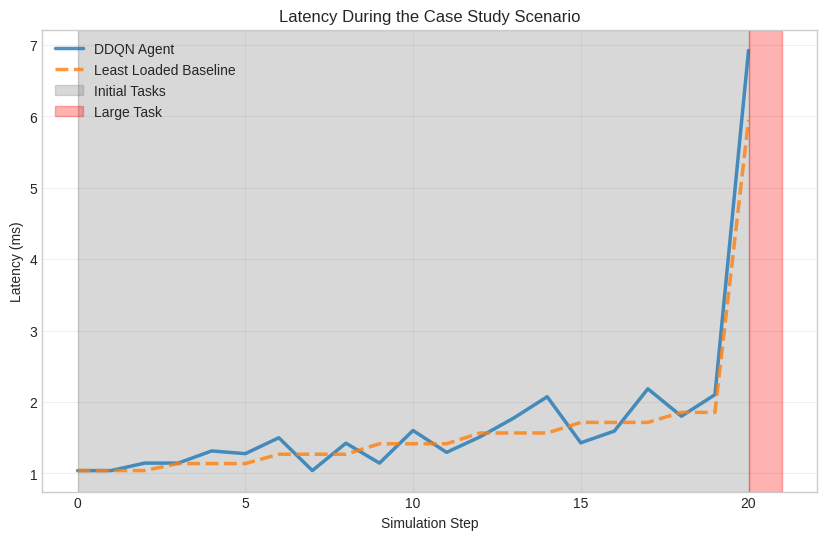

In [7]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# =============================================================================
# 1. Seed & Configuration
# =============================================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# 2. Environment for Case Study
# =============================================================================
class CaseStudyEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_nodes=3, capacity=100.0, base_latency=1.0,
                 latency_penalty_power=2.0, overload_threshold_factor=0.9,
                 catastrophic_factor=1.1):
        super(CaseStudyEnv, self).__init__()
        self.num_nodes = num_nodes
        self.capacity = capacity
        self.base_latency = base_latency
        self.latency_penalty_power = latency_penalty_power
        self.overload_threshold = overload_threshold_factor * self.capacity
        self.catastrophic_threshold = catastrophic_factor * self.capacity

        # Scenario parameters for the case study
        self.steps_per_episode = 100
        self.initial_tasks = 20
        self.initial_task_size = 20.0  # Medium-sized tasks
        self.final_burst_task = 150.0  # A very large task
        self.current_step = 0

        self.action_space = spaces.Discrete(num_nodes)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(num_nodes + 1,), dtype=np.float32)

        self.reset()

    def reset(self, seed=None, options=None):
        self.node_loads = np.zeros(self.num_nodes, dtype=np.float32)
        self.current_step = 0
        self.current_task = self._generate_task()
        return self._get_state(), {}

    def _generate_task(self):
        if self.current_step < self.initial_tasks:
            return self.initial_task_size
        elif self.current_step == self.initial_tasks:
            return self.final_burst_task
        else:
            return float(max(5.0, np.random.normal(15.0, 6.0)))

    def _get_state(self):
        normalized_loads = np.clip(self.node_loads / self.capacity, 0.0, 1.0)
        norm_task = np.clip(self.current_task / self.capacity, 0.0, 1.0)
        return np.concatenate([normalized_loads, [norm_task]]).astype(np.float32)

    def step(self, action):
        self.current_step += 1
        self.node_loads *= (1.0 - 0.05)
        task_load = float(self.current_task)
        projected_load = self.node_loads[action] + task_load
        frac = projected_load / self.capacity
        latency = self.base_latency + (frac ** self.latency_penalty_power)
        reward = -latency

        done = False
        info = {"latency": latency, "node_loads": self.node_loads.copy()}

        if projected_load > self.catastrophic_threshold:
            done = True
            reward -= 500.0
            info['node_loads'][action] += task_load

        self.node_loads[action] += task_load
        self.current_task = self._generate_task()
        return self._get_state(), float(reward), done, False, info

# =============================================================================
# 3. Dueling DQN Architecture & Replay Buffer
# =============================================================================
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden=[128, 128]):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.value_fc = nn.Linear(hidden[1], 64)
        self.value_out = nn.Linear(64, 1)
        self.adv_fc = nn.Linear(hidden[1], 64)
        self.adv_out = nn.Linear(64, action_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        v = torch.relu(self.value_fc(x))
        v = self.value_out(v)
        a = torch.relu(self.adv_fc(x))
        a = self.adv_out(a)
        return v + (a - a.mean(dim=1, keepdim=True))

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayBuffer:
    def __init__(self, capacity): self.memory = deque([], maxlen=capacity)
    def push(self, *args): self.memory.append(Transition(*args))
    def sample(self, batch_size): return random.sample(self.memory, batch_size)
    def __len__(self): return len(self.memory)

# =============================================================================
# 4. Optimized Training Function
# =============================================================================
def train_ddqn_agent(env, policy_net, device, episodes=2000, steps=100,
                     gamma=0.99, lr=1e-4, batch_size=128, epsilon_start=1.0,
                     epsilon_min=0.01, epsilon_decay=0.995, tau=1e-3, learn_after=5000):

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    target_net = DuelingDQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay = ReplayBuffer(capacity=40000)

    epsilon = epsilon_start
    rewards_per_episode = []
    step_count = 0

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0.0

        for t in range(steps):
            step_count += 1
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    st = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = int(policy_net(st).argmax(dim=1).item())

            next_state, reward, done, _, info = env.step(action)
            total_reward += reward
            replay.push(state, action, reward, next_state, done)
            state = next_state

            # Start learning only after sufficient experiences are gathered
            if step_count > learn_after and len(replay) >= batch_size:
                experiences = replay.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*experiences)

                states_t = torch.FloatTensor(np.vstack(states)).to(device)
                actions_t = torch.LongTensor(np.vstack(actions)).to(device)
                rewards_t = torch.FloatTensor(np.vstack(rewards)).to(device)
                next_states_t = torch.FloatTensor(np.vstack(next_states)).to(device)
                dones_t = torch.FloatTensor(np.vstack(dones)).to(device)

                next_a = policy_net(next_states_t).argmax(dim=1, keepdim=True)
                next_q = target_net(next_states_t).gather(1, next_a).detach()
                expected_q = rewards_t + gamma * next_q * (1 - dones_t)

                current_q = policy_net(states_t).gather(1, actions_t)
                loss = nn.MSELoss()(current_q, expected_q)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()

                # Soft update of target network weights
                for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
                    target_param.data.copy_(tau * policy_param.data + (1.0 - tau) * target_param.data)

            if done: break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

        if episode % 100 == 0 or episode == episodes - 1:
            avg_reward = np.mean(rewards_per_episode[-100:])
            print(f"[{time.strftime('%H:%M:%S')}] Episode {episode}, Avg(100) Reward: {avg_reward:.2f}")

    return rewards_per_episode

# =============================================================================
# 5. Case Study Execution and Plotting
# =============================================================================
def run_case_study(policy_net, env, steps=100):

    # Run DDQN agent
    ddqn_latencies = []; ddqn_loads = []
    state, _ = env.reset()
    for _ in range(steps):
        with torch.no_grad():
            st = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            action = int(policy_net(st).argmax(dim=1).item())
        state, _, done, _, info = env.step(action)
        ddqn_latencies.append(info['latency']); ddqn_loads.append(info['node_loads'])
        if done: break

    # Run Least Loaded baseline
    ll_latencies = []; ll_loads = []
    state, _ = env.reset()
    for _ in range(steps):
        action = int(np.argmin(env.node_loads))
        state, _, done, _, info = env.step(action)
        ll_latencies.append(info['latency']); ll_loads.append(info['node_loads'])
        if done: break

    ddqn_loads_df = pd.DataFrame(ddqn_loads, columns=[f'Node {i}' for i in range(env.num_nodes)])
    ll_loads_df = pd.DataFrame(ll_loads, columns=[f'Node {i}' for i in range(env.num_nodes)])

    return ddqn_latencies, ll_latencies, ddqn_loads_df, ll_loads_df

if __name__ == "__main__":

    # 1. TRAIN THE DDQN AGENT
    print("--- Training the DDQN agent for robustness ---")
    training_env = CaseStudyEnv()
    policy_net = DuelingDQN(training_env.observation_space.shape[0], training_env.action_space.n).to(DEVICE)
    train_ddqn_agent(training_env, policy_net, DEVICE, episodes=2000, steps=100)

    # 2. RUN THE CASE STUDY
    print("\n--- Running the case study with the trained DDQN agent ---")
    case_study_env = CaseStudyEnv()
    ddqn_latencies, ll_latencies, ddqn_loads_df, ll_loads_df = run_case_study(policy_net, case_study_env, steps=case_study_env.steps_per_episode)

    # 3. PLOT THE RESULTS
    plt.style.use('seaborn-v0_8-whitegrid')

    # Plot 1: Node Load Over Time
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    ddqn_loads_df.plot(ax=axes[0])
    axes[0].axvspan(0, case_study_env.initial_tasks, color='gray', alpha=0.3, label="Initial Tasks")
    axes[0].axvspan(case_study_env.initial_tasks, case_study_env.initial_tasks + 1, color='red', alpha=0.3, label="Large Task")
    axes[0].set_title('DDQN Agent: Node Load Over Time')
    axes[0].set_xlabel('Simulation Step')
    axes[0].set_ylabel('Normalized Node Load')
    axes[0].legend(loc='upper right')

    ll_loads_df.plot(ax=axes[1])
    axes[1].axvspan(0, case_study_env.initial_tasks, color='gray', alpha=0.3, label="Initial Tasks")
    axes[1].axvspan(case_study_env.initial_tasks, case_study_env.initial_tasks + 1, color='red', alpha=0.3, label="Large Task")
    axes[1].set_title('Least Loaded Baseline: Node Load Over Time')
    axes[1].set_xlabel('Simulation Step')
    axes[1].set_ylabel('Normalized Node Load')
    axes[1].legend(loc='upper right')

    plt.suptitle('Case Study: DDQN vs. Baseline Under a Strategic Load', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Plot 2: Latency per Step
    plt.figure(figsize=(10, 6))
    plt.plot(ddqn_latencies, label="DDQN Agent", linewidth=2.5, alpha=0.8)
    plt.plot(ll_latencies, label="Least Loaded Baseline", linewidth=2.5, alpha=0.8, linestyle='--')
    plt.axvspan(0, case_study_env.initial_tasks, color='gray', alpha=0.3, label="Initial Tasks")
    plt.axvspan(case_study_env.initial_tasks, case_study_env.initial_tasks + 1, color='red', alpha=0.3, label="Large Task")
    plt.title('Latency During the Case Study Scenario')
    plt.xlabel('Simulation Step')
    plt.ylabel('Latency (ms)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()